In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from iuvs import io, scaling

In [3]:
def calc_4_to_3(width):
    height = width * 3 / 4
    return (width, height)

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.rcParams['figure.figsize']= calc_4_to_3(12)
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['image.interpolation'] = 'none'

In [5]:
def get_title(l1b):
    return os.path.basename(l1b.fname)[12:-16]

In [6]:
import os

def show_image_overview(l1b, integration=0, cmap=None):
    if cmap is None:
        cmap = 'binary'
    fig, axes = plt.subplots(nrows=2)
    raw, dark = l1b.get_light_and_dark(integration)
    # raw
    vmin, vmax = np.percentile(raw, (2,98))
    im = axes[0].imshow(raw, vmin=vmin, vmax=vmax, cmap=cmap)
    cb = plt.colorbar(im, ax=axes[0])
    for t in cb.ax.get_yticklabels():
        t.set_fontsize(13)
    axes[0].set_title("raw light")
    # dark
    vmin, vmax = np.percentile(dark, (2,98))
    im2 = axes[1].imshow(dark, vmin=vmin, vmax=vmax, cmap=cmap)
    cb = plt.colorbar(im2, ax=axes[1])
    for t in cb.ax.get_yticklabels():
        t.set_fontsize(13)
    axes[1].set_title('dark')
    fig.suptitle("{} INT_TIME: {}\nP2-P98 stretch. SPA_BIN:{}, SPE_BIN:{}"
                 .format(get_title(l1b),
                         l1b.img_header['INT_TIME'],
                         l1b.img_header['SPA_SIZE'],
                         l1b.img_header['SPE_SIZE']),
                 fontsize=16)
    fig.savefig('plots/'+get_title(l1b)+'_1.png', dpi=150)

In [7]:
import numpy as np

def img_profile_and_stats(img, l1b, title, spatialslice, spectralslice,
                          zmin=None, zmax=None, 
                          spatial=None, spectral=None,
                          ):
    fig, axes = plt.subplots(2, 2)
    if spatial is None:
        spatial = img.shape[0]//2
    if spectral is None:
        spectral = img.shape[1]//2

    
    no_nans = img[~np.isnan(img)]
    sliced = img[spatialslice, spectralslice]
    to_hist = sliced[~np.isnan(sliced)]
    if zmin is None:
        # set vis limits to 2, 98 percentile
        zmin, zmax = np.percentile(no_nans, (2, 98))

    prof1 = img[spatial]
    prof2 = img[:, spectral]
    axes = axes.ravel()
    im = axes[0].imshow(img, vmin=0, vmax=zmax)
    plt.colorbar(im, ax=axes[0])
    min_, max_ = np.percentile(prof2, (2,95))
    axes[1].plot(prof2)
    axes[1].set_ylim(min_, max_)
    axes[1].set_title('Spatial profile at middle spectral value')
    min_, max_ = np.percentile(prof1, (2,95))
    axes[2].plot(prof1)
    axes[2].set_ylim(min_, max_)
    axes[2].set_title('Spectral profile at middle spatial value')
    to_hist = to_hist[to_hist < zmax]
    to_hist = to_hist[to_hist > zmin]
    axes[3].hist(to_hist.ravel(), bins=50, log=False, normed=True)
    axes[3].set_title("Median: {:.1f}, STD: {:.1f}".format(np.median(to_hist),
                                                           to_hist.std()),
                      fontsize=12)
    fig.suptitle("{}, Slice: [{}:{}, {}:{}]\n Img stretch: (0, P98), prof stretch: (P2, P95)"
                 .format(get_title(l1b)+' '+title,
                         spatialslice.start,
                         spatialslice.stop,
                         spectralslice.start,
                         spectralslice.stop),
                 fontsize=16)
    if title == "LIGHT":
        no = 3
    else:
        no = 4
    fig.savefig('plots/'+get_title(l1b)+'_'+str(no)+'.png', dpi=150)

In [8]:
def poly_fitting(fullraw, fulldark, spatialslice, spectralslice, rank):
    light = fullraw[spatialslice, spectralslice]
    dark = fulldark[spatialslice, spectralslice]
    scaler = scaling.PolyScaler(dark, light, rank)
    scaler.do_fit()
    return scaler.apply_fit(fulldark)

def plot_profiles(l1b, spatialslice, spectralslice, rank=2):
    fig, axes = plt.subplots(nrows=4, sharex=True)
    axes = axes.ravel()
    integration_index = -1
    light, dark = l1b.get_light_and_dark(integration_index)
    spatial = light.shape[0]//2
    
    #fitting
    fitted_dark = poly_fitting(light, dark, spatialslice, spectralslice, rank)
    sub = light - fitted_dark
    min_, max_ = np.percentile(sub, (2, 92))
    dbs = l1b.detector_background_subtracted
    if dbs.ndim == 3:
        backsub = dbs[integration_index]
    else:
        backsub = dbs
        
    # raw light
    axes[0].plot(light[spatial])
    p2, p98 = np.percentile(light[spatial], (2,98))
    axes[0].set_ylim(p2, p98)
    axes[0].set_title('Raw light')
    
    # l1b.det_back_subtr
    axes[1].plot(backsub[spatial])
    axes[1].set_ylim(min_, max_)
    axes[1].set_title('l1b.detector_background_subtracted')
    
    # My sub
    axes[2].plot(sub[spatial])
    axes[2].set_ylim(min_, max_)
    axes[2].set_title('subtracted with fitted dark')
    
    # residual
    axes[3].plot(backsub[spatial]-sub[spatial])
    axes[3].set_title('Difference between simple subtracted and scaled-subtracted ')
        
    # title and saving
    fig.suptitle("{} Slice: [{}:{}, {}:{}]\nprofile stretch: (P2, P92), fixed to newest for comparison"
                 .format(get_title(l1b),
                         spatialslice.start,
                         spatialslice.stop,
                         spectralslice.start,
                         spectralslice.stop),
                 fontsize=16)
    fig.savefig('plots/'+get_title(l1b)+'_2.png', dpi=150)
    
    return sub

In [9]:
def plot_mean_profiles(l1b, spatialslice, spectralslice, integration=0, rank=3):
    fig, axes = plt.subplots(nrows=4, sharex=True)
    axes = axes.ravel()
    light, dark = l1b.get_light_and_dark(integration)
    lmean = light.mean(axis=0)
    p2, p98 = np.percentile(lmean, (2,98))
    axes[0].semilogy(lmean)
    axes[0].set_ylim(p2, p98)
    axes[0].set_title('light')
    axes[0].set_ylim(2e3, 1e4)
    
    #fitting
    fitted_dark = poly_fitting(light, dark, spatialslice, spectralslice, rank)
    sub = light - fitted_dark
    min_, max_ = np.percentile(sub, (2, 92))
    
    dbs = l1b.detector_background_subtracted
    if dbs.ndim == 3:
        backsub = dbs[0]
    else:
        backsub = dbs
        
    axes[1].plot(backsub.mean(axis=0))
    axes[1].set_ylim(min_, max_)
    axes[1].set_title('detetor_background_subtracted')
    
    # my sub
    axes[2].plot(sub.mean(axis=0))
    axes[2].set_ylim(min_, max_)
    axes[2].set_title('subtracted with fitted dark')
    
    # residual
    axes[3].plot(backsub.mean(axis=0)-sub.mean(axis=0))
    axes[3].set_title('Difference between simple subtracted and scaled-subtracted ')
    
    # title and saving
    fig.suptitle("{} Slice: [{}:{}, {}:{}]\nprofile stretch: (P2, P92), fixed to newest for comparison"
                 .format(get_title(l1b),
                         spatialslice.start,
                         spatialslice.stop,
                         spectralslice.start,
                         spectralslice.stop),
                 fontsize=16)
    fig.savefig('plots/'+get_title(l1b)+'_2.png', dpi=150)
    return sub

In [10]:
fname = io.l1b_filenames()[0]
fname

'/Users/klay6683/data/iuvs/level1b/mvn_iuv_l1b_apoapse-orbit00107-mode2001-fuv_20141018T091335_v01_r01.fits.gz'

In [149]:
l1b = io.L1BReader(fname)

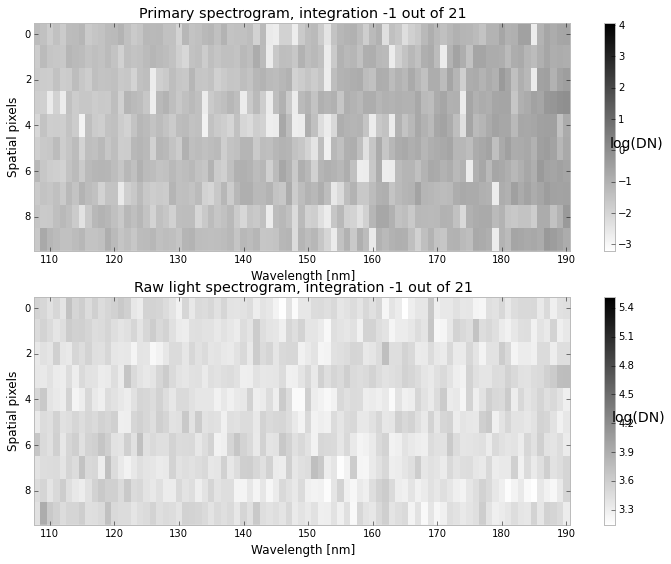

In [157]:
fig, ax= plt.subplots(nrows=2)
l1b.plot_img_spectrogram(-1, ax=ax[0])
l1b.plot_raw_spectrogram(-1, ax=ax[1])

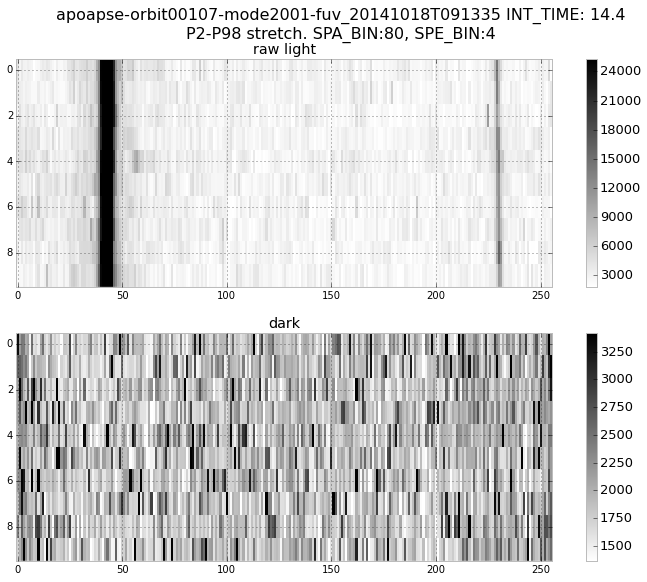

In [15]:
show_image_overview(l1b)

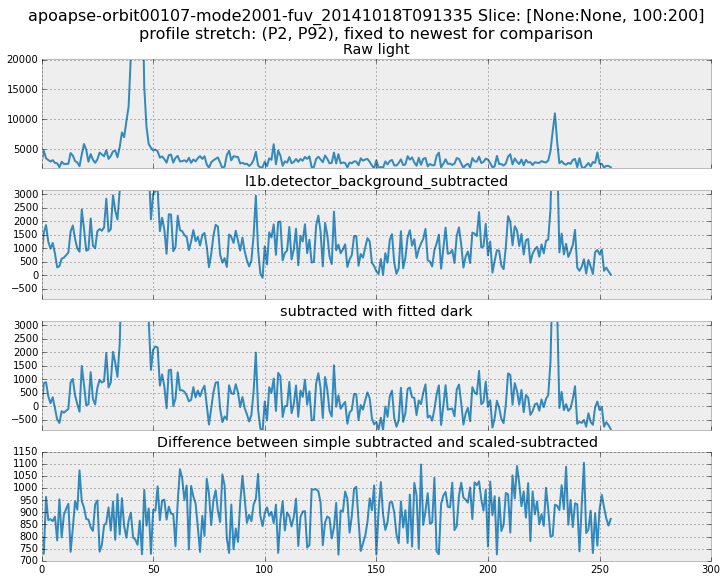

In [16]:
spa_slice = slice(None, None)
spe_slice = slice(100, 200)
sub = plot_profiles(l1b, spa_slice, spe_slice, rank=3)

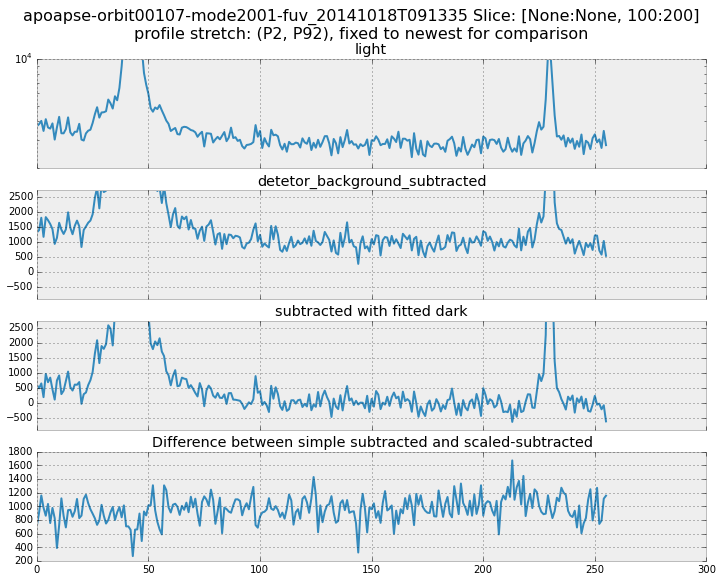

In [17]:
spa_slice = slice(None, None)
spe_slice = slice(100, 200)
sub = plot_mean_profiles(l1b, spa_slice, spe_slice, rank=3)

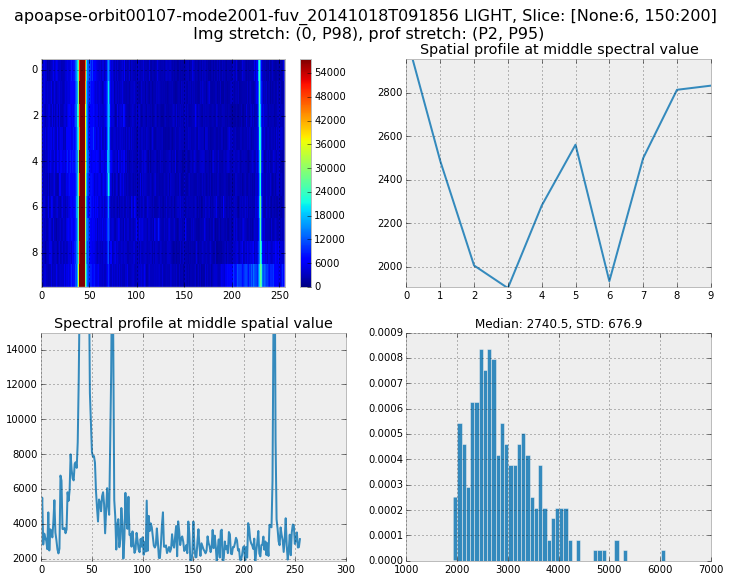

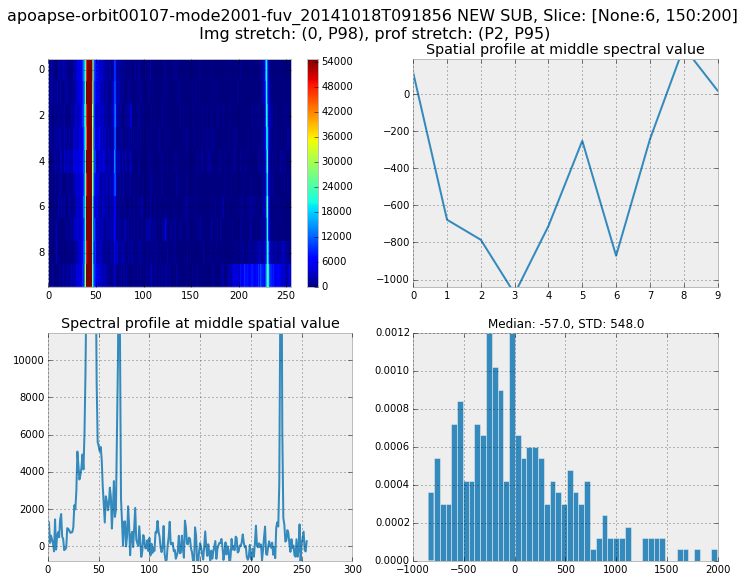

In [48]:
from IPython.display import display

In [126]:
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

def make_spectogram(l1b, data_attr, fps):
    data = getattr(l1b, data_attr)
    fig_mpl, ax = plt.subplots(1, figsize=(10,6), facecolor='white')
    xx = l1b.wavelengths[0]
    zz = lambda x: np.log(data[x])
    ax.set_title(data_attr)
    ax.set_xlim(xx[0], xx[-1])
    ax.axis('off')
    im = ax.imshow(zz(0), cmap='binary')
    
    duration = len(data) / fps
    
    def make_frame_mpl(t):
        index = int(t*fps)
        im.set_data( zz(index))  # <= Update the curve
        ax.set_title('Spectogram {} out of {}'.format(index+1, len(data)))
        return mplfig_to_npimage(fig_mpl) # RGB image of the figure

    animation =mpy.VideoClip(make_frame_mpl, duration=duration)
    animation.write_videofile(data_attr+".mp4", fps=fps)
    animation.write_gif(data_attr+'.gif', fps=fps)

In [120]:
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

def make_line_profile(l1b, data_attr, fps, spatial=None):
    data = getattr(l1b, data_attr)
    if spatial is None:
        spatial = data.shape[1]//2
    fig_mpl, ax = plt.subplots(1, figsize=(10,6), facecolor='white')
    xx = l1b.wavelengths[0]
    zz = lambda x: data[x][spatial]
    ax.set_title(data_attr)
    ax.set_xlim(xx[0], xx[-1])
    line, = ax.semilogy(xx, zz(0), lw=3)
    
    duration = len(data) / fps
    
    def make_frame_mpl(t):
        index = int(t*fps)
        line.set_ydata(zz(index))
        ax.set_title('t: {}, Profile {} at spatial {} out of {}'
                     .format(t, index+1, spatial, len(data)))
        return mplfig_to_npimage(fig_mpl)
    
    animation = mpy.VideoClip(make_frame_mpl, duration=duration)
    animation.write_videofile(data_attr+'_profiles.mp4', fps=fps)
    animation.write_gif(data_attr+'_profiles.gif', fps=fps)

[MoviePy] >>>> Building video detector_raw_profiles.mp4
[MoviePy] Writing video detector_raw_profiles.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: detector_raw_profiles.mp4 


[MoviePy] Building file detector_raw_profiles.gif with imageio


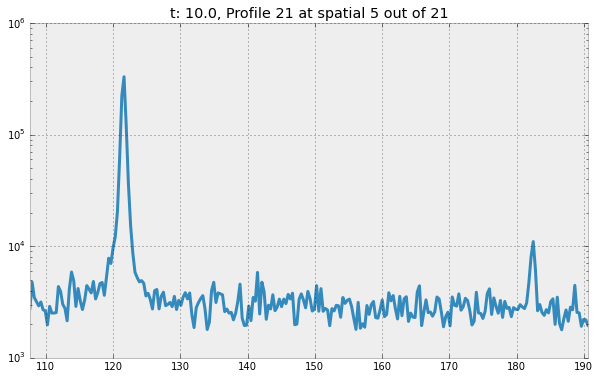

In [121]:
make_line_profile(l1b, 'detector_raw', 2)

[MoviePy] >>>> Building video detector_raw.mp4
[MoviePy] Writing video detector_raw.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: detector_raw.mp4 


[MoviePy] Building file detector_raw.gif with imageio


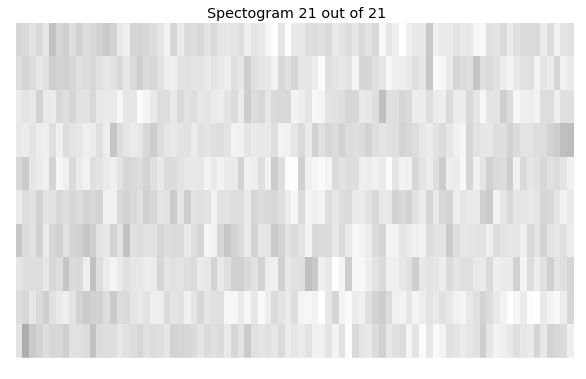

In [127]:
make_spectogram(l1b, 'detector_raw', 2)

In [128]:
clip_mayavi = mpy.VideoFileClip("detector_raw.mp4")
clip_mpl = mpy.VideoFileClip("detector_raw_profiles.mp4") #.resize(height=clip_mayavi.h)
animation = mpy.clips_array([[clip_mpl], [clip_mayavi]])
animation.write_videofile("combined.mp4", fps=2)
animation.write_gif('combined.gif', fps=2)

[MoviePy] >>>> Building video combined.mp4
[MoviePy] Writing video combined.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: combined.mp4 


[MoviePy] Building file combined.gif with imageio


In [129]:
clip_mayavi2 = (clip_mayavi.fx( mpy.vfx.mask_color, [255,255,255])
                .set_opacity(.4) # whole clip is semi-transparent
                .resize(height=0.85*clip_mpl.h)
                .set_pos('center'))

animation = mpy.CompositeVideoClip([clip_mpl, clip_mayavi2])
animation.write_gif("combined_in_one.gif", fps=20)

ImportError: fx resize needs OpenCV or Scipy or PIL

In [135]:
%timeit data.mean(axis=(1,2))

The slowest run took 6.06 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 3: 241 µs per loop


In [136]:
data.shape

(21, 10, 256)